# Прогнозирование временных рядов на карте. Работа с геоданными
В этом задании вам предстоит научиться работать с географическими данными. В Питоне есть огромное количество библиотек, позволяющих эти данные обрабатывать и визуализировать; выберите ту, которая вам больше понравится. Вам может помочь руководство kaggle по работе с картами: "Семнадцать способов рисовать данные на картах". Смотрите также:

- модуль basemap (пример, ещё пример)
- плагин gmaps
- виджет ipyleaflet (крайне минималистичный пример)
- модуль folium

Поскольку мы агрегировали данные по равномерной сетке, можно ожидать, что существенное количество ячеек окажется в районах города, где вызов такси невозможен (реки, заливы, острова, парки). Теоретически ряды, соответствующие таким ячейка, должны состоять из одних нулей, но на практике это может быть не так: устройства, определяющие координаты автомобилей в момент начала поездки, несовершенны и могут ошибаться, показывая, например, что такси находится в середине реки. Чтобы правильно отобрать ячейки, вам понадобится визуализировать их границы на карте и отфильтровать те, из которых поездки на такси невозможны.

Чтобы сдать задание, выполните следующую последовательность действий:

(1) Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [1]:
# импортируем необходимые библиотеки
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import plotly
import plotly.plotly as py
from plotly.graph_objs import *

In [2]:
# сохраняем параметры для рассматриваемого месяца
month_dt = '2016-05' # для файлов

In [3]:
# загружаем агрегированные данные
aggr_data = pickle.load( open( 'aggr_'+month_dt+'.p', "rb" ) )
aggr_data.shape

(2500, 744)

In [4]:
# считаем общее количество поездок из каждой географической зоны
rides_regions=[]
zero_rides_regions=0
for x in aggr_data:
    rides_num=x.sum()
    rides_regions.append(rides_num)
    if rides_num==0:
        zero_rides_regions+=1
print('количество зон, из которых 2016-05 не было совершено ни одной поездки =',zero_rides_regions)

количество зон, из которых 2016-05 не было совершено ни одной поездки = 1283


(2) Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

(3) Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [5]:
# Границы Нью-йорка
NY_west=-74.25559
NY_east=-73.70001
NY_south=40.49612
NY_north=40.91553

# координаты Empire State Building
ESB_lon = [-73.985756,]
ESB_lat = [40.748306,]

# функция для рисования прямоугольников на карте
def draw_screen_poly( lats, lons, m,alpha_value):
    x, y = m( lons, lats )
    xy=[]
    for i in range(len(x)):
        xy.append([x[i],y[i]])
    poly = Polygon( xy, facecolor='red', alpha=alpha_value )
    plt.gca().add_patch(poly)

# максимальное количество поездок за месяц
max_rides = max(rides_regions)

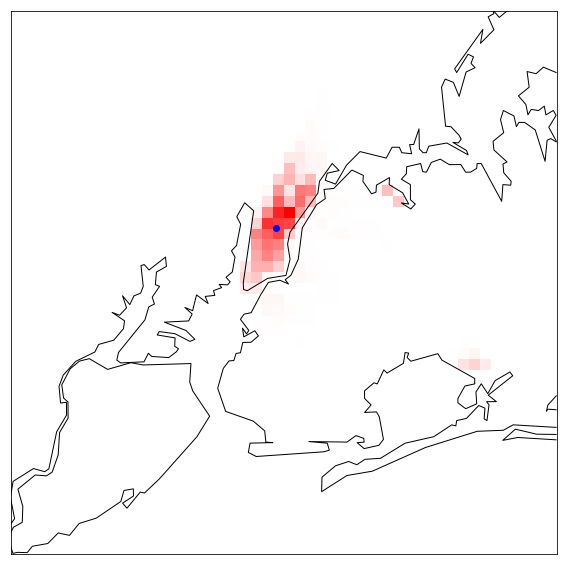

In [7]:
# инициализируем объект класса Basemap
plt.rcParams['figure.figsize'] = (20.0, 10.0)
m = Basemap(projection='merc', resolution = 'h', 
              llcrnrlon= NY_west, llcrnrlat= NY_south,
              urcrnrlon= NY_east, urcrnrlat= NY_north)

# формируем изображения районов с раскраской соответственно интенсивности поездок
regions = pd.read_csv('regions.csv', sep = ';')
for index, row in regions.iterrows():
    draw_screen_poly( [row.south, row.north, row.north ,row.south], [row.west, row.west,row.east,row.east], m, 1.0*rides_regions[index]/max_rides )

#рисуем контуры побережий 
m.drawcoastlines()

# рисуем Empire State Building
x,y = m(ESB_lon, ESB_lat)
m.plot(x, y, 'bo', markersize=6)

- Синим маркетом отмечено здание Empire State Building.
- Интенсивность красного показывает количество поездок из соответствующего района

(4) Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [21]:
# Координаты статуи свободы
sl_lat= 40.689247
sl_lon=-74.044502

# Инициализируем токен для доступа к mapbox
mapbox_access_token = 'pk.eyJ1Ijoib2Jyb2NrIiwiYSI6ImNqYzNyOHFtZjBwMWozM24ybGh1a21qamQifQ.zeA41dKuN395dVoRuc1LmA'

# ставим метку статуи свободы
data = Data([
    Scattermapbox(
        lat=[str(sl_lat)],
        lon=[str(sl_lon)],
        mode='markers',
        marker=Marker(
            size=10,
            color='rgb(0, 0, 255)',
            opacity=1.0
        ),
        text=['Statue of Liberty'],
        showlegend = False 
    )
])
   
# инициализируем первоначальное увеличение и позицию на карте
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.689247,
            lon=-74.044502
        ),
        pitch=0,
        zoom=10
    ),
)

# рисуем карту
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='NY Mapbox')

- На интерактивной карте синим маркером отмечена Статуя Свободы.

(5) Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [51]:
# Координаты статуи свободы
sl_lat= 40.689247
sl_lon=-74.044502

# Инициализируем токен для доступа к mapbox
mapbox_access_token = 'pk.eyJ1Ijoib2Jyb2NrIiwiYSI6ImNqYzNyOHFtZjBwMWozM24ybGh1a21qamQifQ.zeA41dKuN395dVoRuc1LmA'

# ставим метку статуи свободы
data = Data([
    Scattermapbox(
        lat=[str(sl_lat)],
        lon=[str(sl_lon)],
        mode='markers',
        marker=Marker(
            size=10,
            color='rgb(0, 0, 255)',
            opacity=1.0
        ),
        text=['Statue of Liberty'],
        showlegend = False 
    )
])

# Для ускорения построения графика сгруппируем все раойны в 101 группу в зависимости от количества поездок. 
# Если рисовать каждый отдельный регион отдельно, то отрисовка карты занимает слишком много времени.
data_for_map=[[[],[],[]] for x in range(101)]
for index, row in regions.iterrows():
    data_for_map[int(100*rides_regions[index]/max_rides)][0].append(str((row.south+ row.north)/2))
    data_for_map[int(100*rides_regions[index]/max_rides)][1].append(str((row.west+row.east)/2))
    data_for_map[int(100*rides_regions[index]/max_rides)][2].append('ID_'+str(int(row.region))+'; AvgRides='+str(int(rides_regions[index]/aggr_data.shape[1])))
    
# ставим метки для районов и красим их соответственно интенсивности поездок
for i in range(len(data_for_map)) :
    data+=  Data([
    Scattermapbox(
        lat=data_for_map[i][0],
        lon=data_for_map[i][1],
        mode='markers',
        marker=Marker(
            size=10,
            color='rgb(255, 0, 0)',
            opacity=0.9*i/100 +0.1
        ),
        showlegend = False,
        text= data_for_map[i][2],
    )
])
    
# инициализируем первоначальное увеличение и позицию на карте
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.689247,
            lon=-74.044502
        ),
        pitch=0,
        zoom=9
    ),
)

# рисуем карту
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='NY Mapbox')

- На интерактивной карте синим маркером отмечена Статуя Свободы.
- Интенсивность красного для остальных маркеров отражает среднечасовое количество поездок.
- При наведении курсора на маркер показывается дополнительная информация.
- Поскольку не очень понятно как рисовать полигоны в Plotly (Mapbox), интенсивность поездок для региона оторбражается через маркер, поставленный в центре этого региона.

(6) Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [28]:
# Координаты статуи свободы
sl_lat= 40.689247
sl_lon=-74.044502

# Инициализируем токен для доступа к mapbox
mapbox_access_token = 'pk.eyJ1Ijoib2Jyb2NrIiwiYSI6ImNqYzNyOHFtZjBwMWozM24ybGh1a21qamQifQ.zeA41dKuN395dVoRuc1LmA'

# ставим метку статуи свободы
data = Data([
    Scattermapbox(
        lat=[str(sl_lat)],
        lon=[str(sl_lon)],
        mode='markers',
        marker=Marker(
            size=10,
            color='rgb(0, 0, 255)',
            opacity=1.0
        ),
        text=['Statue of Liberty'],
        showlegend = False 
    )
])

# ставим метки для районов и красим их соответственно интенсивности поездок
n_remain=0
for index, row in regions.iterrows():
    if rides_regions[index]>aggr_data.shape[1]*5:
        n_remain+=1
        data+=  Data([
        Scattermapbox(
            lat=[str((row.south+ row.north)/2)],
            lon=[str((row.west+row.east)/2)],
            mode='markers',
            marker=Marker(
                size=14,
                color='rgb(255, 0, 0)',
                opacity=1.0*rides_regions[index]/max_rides
            ),
            showlegend = False,
            text= ['ID_'+str(int(row.region))+'; AvgRides='+str(int(rides_regions[index]/aggr_data.shape[1]))],
        )
    ])
    
# инициализируем первоначальное увеличение и позицию на карте
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.689247,
            lon=-74.044502
        ),
        pitch=0,
        zoom=9.5
    ),
)

# рисуем карту
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='NY Mapbox')

In [26]:
print('Количество отмеченных ячеек =', n_remain)

Количество отмеченных ячеек = 102


- На интерактивной карте синим маркером отмечена Статуя Свободы.
- Интенсивность красного для остальных маркеров отражает среднечасовое количество поездок.
- При наведении курсора на маркер показывается дополнительная информация.
- Похоже, что из всех районов отмеченных на карте поездки вполне возможны.

In [8]:
regions

,region,west,east,south,north
0,1,-74.255590,-74.244478,40.496120,40.504508
1,2,-74.255590,-74.244478,40.504508,40.512896
2,3,-74.255590,-74.244478,40.512896,40.521285
3,4,-74.255590,-74.244478,40.521285,40.529673
4,5,-74.255590,-74.244478,40.529673,40.538061
5,6,-74.255590,-74.244478,40.538061,40.546449
6,7,-74.255590,-74.244478,40.546449,40.554837
7,8,-74.255590,-74.244478,40.554837,40.563226
8,9,-74.255590,-74.244478,40.563226,40.571614
9,10,-74.255590,-74.244478,40.571614,40.580002


In [18]:
# ставим метки для районов и красим их соответственно интенсивности поездок
chosenRegions_0BasedIndex = []
n_remain=0
for index, row in regions.iterrows():
    if rides_regions[index]>aggr_data.shape[1]*5:
        n_remain+=1
        chosenRegions_0BasedIndex.append(index)

pickle.dump(aggr_data, open( 'aggr_'+month_dt+'.p', "wb" ) )
        
print(len(chosenRegions_0BasedIndex))

1074
1075
1076
1124
1125
1126
1127
1128
1129
1130
1131
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1220
1221
1222
1223
1224
1226
1227
1228
1229
1230
1231
1232
1233
1234
1271
1272
1273
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1325
1326
1330
1331
1332
1333
1334
1335
1336
1337
1338
1375
1376
1377
1379
1381
1382
1383
1384
1385
1386
1387
1388
1389
1425
1430
1433
1434
1435
1436
1437
1438
1440
1441
1479
1481
1482
1529
1531
1532
1579
1629
1683
1732
1733
1782
2067
2068
2117
2118
2167
102


In [14]:
pickle.dump(chosenRegions_0BasedIndex, open( 'chosenRegions_0BasedIndex.p', "wb" ))